In [1]:
import numpy as np
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import geone
import geone.covModel as gcm
import geone.geosclassicinterface as gci
import geone.imgplot3d as imgplt3
import pyvista as pv
import os
import sys
import pickle
import shapely
import geopandas as gp
import rasterio
from shapely.geometry import Polygon, MultiPolygon

#my modules
import ArchPy
from ArchPy.base import *

In [2]:
def ArchPy_call_function(select_location = "polygon", nreal_units = 0, nreal_facies = 0, nreal_prop = 0,
                         workspace = "ArchPy_workspace", modelname = "model1",
                         bh_file = "model1.lbh", unit_file = "model1.ud", facies_file= "model1.fd"):
    
    """
    ArchPy all in one function to call a model, select a region, change the grid size, etc.
    
    ## inputs ##
    select_location : string, how to select the region to model.
                      "polygon", "all", "zones" and default are valid options
    
    workspace       : Folder where the ArchPy model is
    nreal_units     : int, number of realizations for units
    nreal_facies    : int, number of realizations for facies
    nreal_prop      : int, number of realizations for properties
    """
    
    #load files
    ud = pd.read_csv(os.path.join(workspace, unit_file))  # unit data
    fd = pd.read_csv(os.path.join(workspace, facies_file))
    bhs = pd.read_csv(os.path.join(workspace, bh_file))
    
    default_grid = False
    ## Selection of the modeling zone
    if select_location == "polygon":
        
        # choose a matplolib GUI
        %matplotlib tk 
        
        fig,ax = plt.subplots()
        
        # plot boreholes locations
        ax.scatter(bhs.bh_x, bhs.bh_y, s=10, c="k")
        Lx = bhs.bh_x.max() - bhs.bh_x.min()
        Ly = bhs.bh_y.max() - bhs.bh_y.min()
        
        # adjust ax limits
        mult = 0.05
        inc_x = Lx * mult
        inc_y = Ly * mult

        ax.set(xlim=(bhs.bh_x.min() - inc_x, bhs.bh_x.max() + inc_x),
               ylim=(bhs.bh_y.min() - inc_y, bhs.bh_y.max() + inc_y))
        
        #draw polygon on ax
        obj = ArchPy.inputs.drawPoly()
        obj.draw(ax, typ="polygon")
        plt.show(block = True)  # to stop the code until the polygon is drawn

        #to use drawn polygon
        poly_data = obj.list_p

        #use ginput instead --> if polygon does not work
        #poly_data = [plt.ginput(n=-1, timeout=0)]

        plt.close()  # close figure
        
    elif select_location == "zones":  # predifined zones TO DO
        pass
    
    elif select_location == "all":
        ox = bhs.bh_x.min()
        x1 = bhs.bh_x.max()
        oy = bhs.bh_y.min()
        y1 = bhs.bh_y.max()
        Lx = x1 - ox
        Ly = y1 - oy
        mult = 0.05
        inc_x = Lx * mult
        inc_y = Ly * mult
        
        ox -= inc_x
        oy -= inc_y
        x1 += inc_x
        y1 += inc_y
        
        poly_data = ([[[ox, oy], [ox, y1], [x1, y1], [x1, oy], [ox, oy]]])
        
    elif select_location == "default":
        default_grid = True
        pass
    else:
        raise ValueError ("invalid selection location method")

    if select_location != "default":
        
        # create multipolygon shapely  --> get coordinates from the polygon and create a shapely polygon object
        l_p = []
        for p in poly_data:
            l_p.append(Polygon(p))
        p1 = MultiPolygon(l_p)


        ## Select boreholes that are inside the polygon
        # set cell id as names to grid cells and create shapely point object from borehole locations
        bhs_points = []
        i=0
        for ix,iy in zip(bhs.bh_x, bhs.bh_y):
            po = shapely.geometry.Point(ix, iy)
            po.name = i
            i+=1
            bhs_points.append(po)

        #check position, only keep points inside polygon
        l=[]
        for po in bhs_points:
            if po.intersects(p1):
                l.append(po.name)


        # operate selection 
        bhs_sel = bhs.loc[np.array(l)]
        fd_sel = fd[fd["bh_ID"].isin(bhs_sel["bh_ID"])] # facies data selection
        ud_sel = ud[ud["bh_ID"].isin(bhs_sel["bh_ID"])] # unit data selection

        # return to standard display
        %matplotlib inline 

        fig,ax = plt.subplots()
        ax.scatter(bhs.bh_x, bhs.bh_y, s=10, c="k")
        ax.scatter(bhs_sel.bh_x, bhs_sel.bh_y, s=10, c="r")

        #plot extent
        x,y = p1[0].exterior.xy
        ax.plot(x, y, c="k")

        Lx = bhs.bh_x.max() - bhs.bh_x.min()
        Ly = bhs.bh_y.max() - bhs.bh_y.min()

        # adjust ax limits
        mult = 0.1
        inc_x = Lx * mult
        inc_y = Ly * mult

        ax.set(xlim=(bhs.bh_x.min() - inc_x, bhs.bh_x.max() + inc_x),
               ylim=(bhs.bh_y.min() - inc_y, bhs.bh_y.max() + inc_y))
        plt.show()
        
        import_grid = False  # flag for import_project function to not import the grid
        
        Lx_domain = np.round(np.max(x) - np.min(x), 2)
        Ly_domain = np.round(np.max(y) - np.min(y), 2)
        print("\n Grid settings (Please enter desired numbers)")
        print("Lx = {} / Ly = {} ".format(Lx_domain, Ly_domain))
        sx=int(input("sx = "))
        sy=int(input("sy = "))
        sz = int(input("sz = "))
        
        print("max/min altitudes in boreholes {}/{}".format(min([iz - idepth for iz, idepth in zip(bhs_sel.bh_z, bhs_sel.bh_depth)]),
                                                            max([iz for iz in bhs_sel.bh_z])))
        oz=int(input("oz = "))
        z1=int(input("zmax = "))
        xg = np.arange(p1.bounds[0], p1.bounds[2]+sx,sx)
        nx = len(xg)-1
        yg = np.arange(p1.bounds[1], p1.bounds[3]+sy,sy)
        ny = len(yg)-1
        zg = np.arange(oz,z1+sz,sz)
        nz = len(zg)-1
        dimensions = (nx, ny, nz)
        spacing = (sx, sy, sz)
        origin = (p1.bounds[0], p1.bounds[1], oz)
        
    else:
        import_grid = True
        
    
    #load arch table object from existing pile
    T1 = ArchPy.inputs.import_project(modelname, ws=workspace, 
                                      import_bhs=False, import_grid=import_grid, import_results=False)
    
    # remove facies from table to keep only ones that are
    list_facies = T1.get_all_facies()
    T1.rem_all_facies_from_units()
    
    if not import_grid:
        T1.add_grid(dimensions, spacing, origin, polygon=p1, top=None, bot=None)
        db, list_bhs = load_bh_files(bhs_sel, fd_sel.reset_index(), ud_sel.reset_index(), altitude = True)
    else:
        db, list_bhs = load_bh_files(bhs, fd.reset_index(), ud.reset_index(), altitude = True)

    ## The following lines are needed to adjust units and facies if they are present in the db.
    ## If a unit is not present, it is removed from the pile to avoid issues
    t = db.copy()
    
    for unit in T1.get_all_units():
        if unit.name not in db.Strat_ID.unique():
            for pile in T1.get_piles():
                pile.remove_unit(unit)
                
    # Facies
    for unit in t["Strat_ID"].unique():
        if T1.get_unit(unit) is not None:
            facies_in_unit = t.loc[t.Strat_ID == unit].Facies_ID.unique()
            for fa in list_facies:
                if fa.name in facies_in_unit:
                    T1.get_unit(unit).add_facies(fa)
                    
    #extract and add boreholes to the main object
    all_boreholes = extract_bhs(db, list_bhs, T1, units_to_ignore=())
    T1.add_bh(all_boreholes)
    
    # process data
    T1.bhs_processed=0  # reinitialize flag that indicates that data have been processed
    T1.erase_hd()  # erase previous process data 
    T1.process_bhs()  # process data
    
    #simulations
    T1.compute_surf(nreal_units)
    T1.compute_facies(nreal_facies)
    T1.compute_prop(nreal_prop)
        
    return T1

Select your region
Use left button to select you area(s)
Polygon added - please press esc if you want to draw another or close the window when you have finished


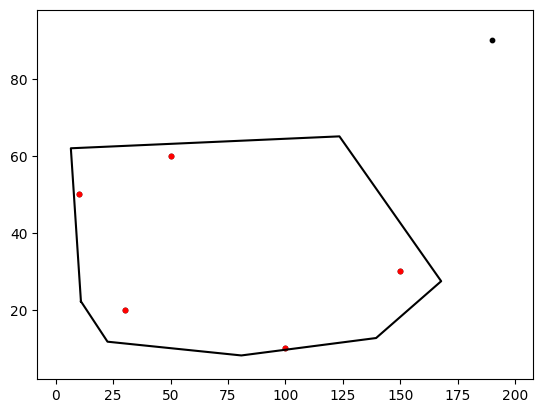


 Grid settings (Please enter desired numbers)
Lx = 161.27 / Ly = 56.9 
sx = 1
sy = 1
sz = 1
max/min altitudes in boreholes -14.925/-6.01
oz = -16
zmax = -6
### IMPORTING PROJECT model1 IN ArchPy_workspace DIRECTORY ### 

Unit A: Surface added for interpolation
Facies basement added to unit A
The SubPile object is not an Arch_table object
Unit B: Surface added for interpolation
Facies Sand added to unit B
Facies Gravel added to unit B
Facies GM added to unit B
Facies SM added to unit B
Unit B1: Surface added for interpolation
Facies Sand added to unit B1
Facies Gravel added to unit B1
Facies GM added to unit B1
Facies SM added to unit B1
Unit B2: Surface added for interpolation
Facies Sand added to unit B2
Facies Gravel added to unit B2
Facies GM added to unit B2
Facies SM added to unit B2
Unit B3: Surface added for interpolation
Facies Sand added to unit B3
Facies Gravel added to unit B3
Facies GM added to unit B3
Facies SM added to unit B3
Unit C: Surface added for interpolation
Faci

In [3]:
T1 = ArchPy_call_function(select_location="polygon", nreal_units=1, nreal_facies=1, nreal_prop=1)

In [4]:
T1.plot_bhs("facies")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [5]:
T1.plot_units()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [6]:
T1.plot_facies()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [7]:
T1.plot_prop("K")

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)